# MODELO CLASIFICADOR

1) Separar dataset en set de training y set de test -> train_test_split

2) Ajustar hiperparámetros para los distintos modelos de clasificación:

    a) K-Neighbors
    
    b) SVC
    
    c) Árbol de decisión
    
    d) Ensembles (Random Forest, XGBoost, Bagging Classifier...)
    
3) Análisis de resultados: Classification report, matriz de confusión y elección del modelo
 

Importamos librerías necesarias

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import altair as alt

%matplotlib inline
plt.style.use('ggplot')

#Librerías para modelos

#k-neighbors
from sklearn.neighbors import KNeighborsClassifier
#SVC
from sklearn.svm import SVC
#Arbol de decision
from sklearn.tree import DecisionTreeClassifier
#Regresión logística
from sklearn.linear_model import LogisticRegression
#Para agrupar clasificadores
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE

from sklearn.metrics import classification_report, confusion_matrix

#Para representar el arbol

import pydotplus
from IPython.display import Image
from sklearn import tree

In [3]:
pd.options.display.max_columns= None

Descargamos los datos previamente procesados y almacenados en *data_processed/data_processed_definitive.csv*

In [4]:
df=pd.read_csv('../data_processed/data_processed_definitive.csv',sep=';',index_col=False,parse_dates=['FECHA'])
df.head(3)

,FECHA,PERIODO,MES,WD,PRECIO_MD_ESP,ACOPLADO_FR,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,CARBON_D-1,EMB_ANUALES,EMB_HIPERANUALES,RESERVA
0,2015-10-01,1,10,4,56.65,0,0,2196.1,24517.1,10060.7,326.43,3714,4909,1
1,2015-10-01,2,10,4,53.50,0,0,2064.4,23168.6,10060.7,307.80,3714,4909,0
2,2015-10-01,3,10,4,49.69,0,0,1866.5,22437.2,10060.7,298.16,3714,4909,0


### 1) Creo train_test_set

**NOTA:** Tras la exploración de datos, en un primer intento decido quedarme con todos los features seleccionados.

In [5]:
attributes_column = list(df.drop(['FECHA','RESERVA'],axis=1).columns) 

In [6]:
X=df[attributes_column]
y=df['RESERVA']

Aplico train_test_split para separar aleatoriamente mi dataset en un set de entrenamiento y otro de test fijando la semilla.

Como en el notebook de exploración se veía que algunos features como ACOPLAMIENTO_FR estaban sesgados o, por ejemplo, la magnitud de PRECIO_MD era muy distinta un año vs. otro, compruebo que mis subconjuntos son representativos del set entero con algunos gráficos.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

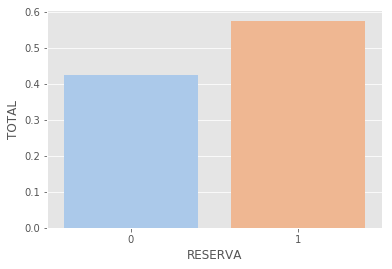

RESERVA=1: 0.576


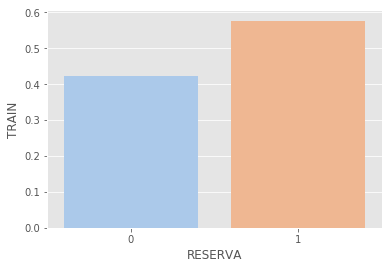

RESERVA=1: 0.577


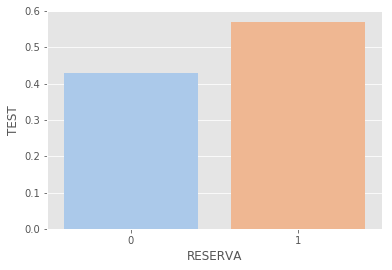

RESERVA=1: 0.571


In [8]:
PORC=y.value_counts(normalize=True,sort=False).reset_index()
PORC.columns=(['RESERVA','TOTAL'])
PORC['TRAIN']=y_train.value_counts(normalize=True,sort=False).values
PORC['TEST']=y_test.value_counts(normalize=True,sort=False).values

sns.barplot(x='RESERVA',y='TOTAL',data=PORC,palette='pastel');
plt.show()
print('RESERVA=1: %.3f' %PORC['TOTAL'].loc[1])

sns.barplot(x='RESERVA',y='TRAIN',data=PORC,palette='pastel');
plt.show()
print('RESERVA=1: %.3f' %PORC['TRAIN'].loc[1])

sns.barplot(x='RESERVA',y='TEST',data=PORC,palette='pastel');
plt.show()
print('RESERVA=1: %.3f' %PORC['TEST'].loc[1])

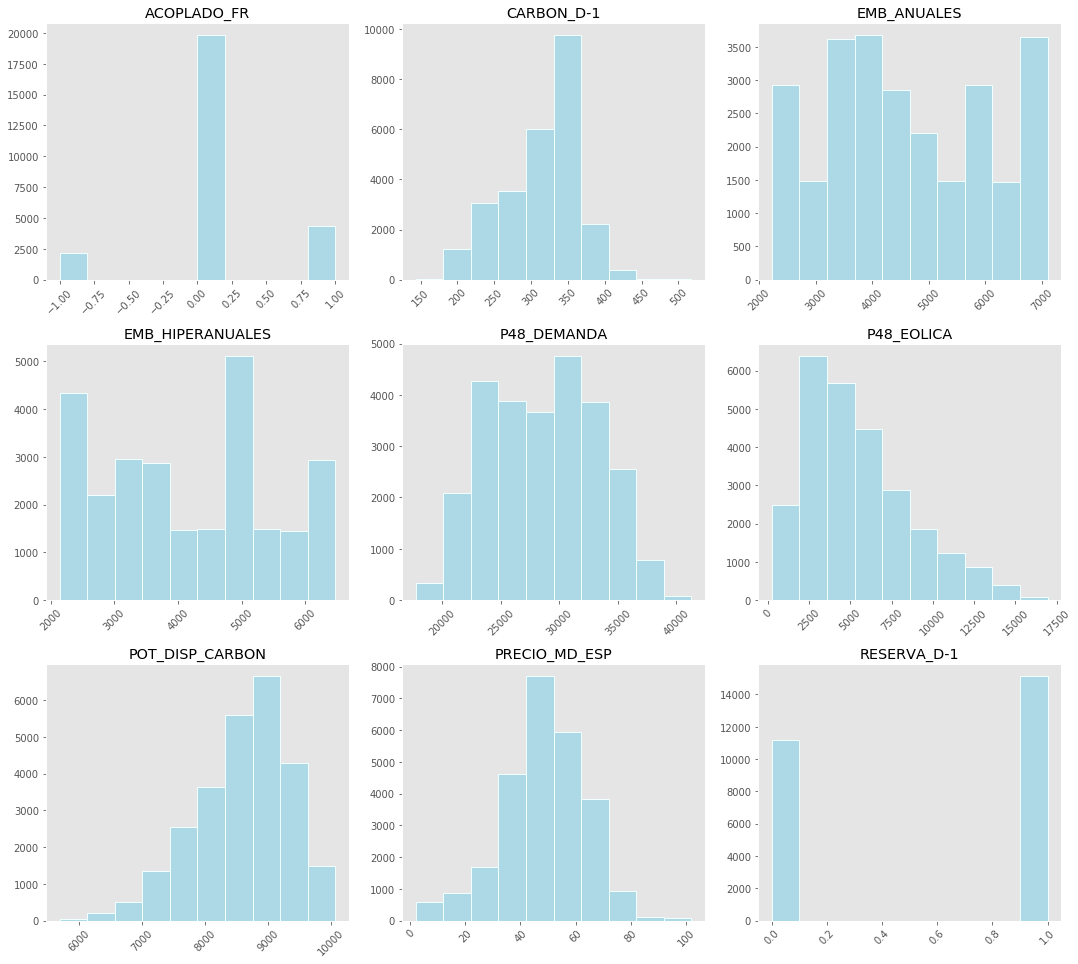

In [9]:
fig = X.drop(['MES','PERIODO','WD'],axis=1).hist(color='lightblue',
                                                    edgecolor='azure', linewidth=1.0,
                                                    xlabelsize=10, ylabelsize=10,
                                                    xrot=45, yrot=0,
                                                    figsize=(10,9),
                                                    grid=False)
plt.tight_layout(rect=(0, 0, 1.5, 1.5))  

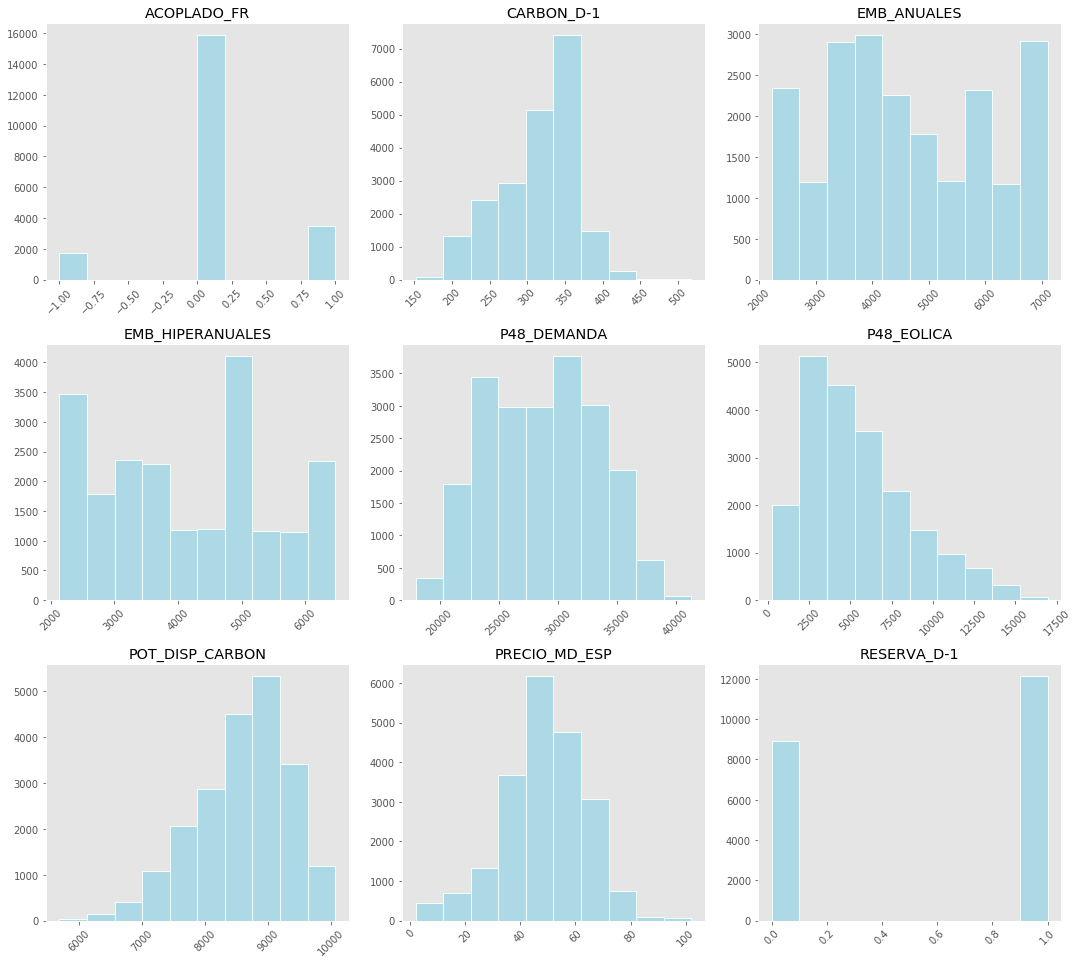

In [10]:
fig = X_train.drop(['MES','PERIODO','WD'],axis=1).hist(color='lightblue',
                                                    edgecolor='azure', linewidth=1.0,
                                                    xlabelsize=10, ylabelsize=10,
                                                    xrot=45, yrot=0,
                                                    figsize=(10,9),
                                                    grid=False)
plt.tight_layout(rect=(0, 0, 1.5, 1.5))  

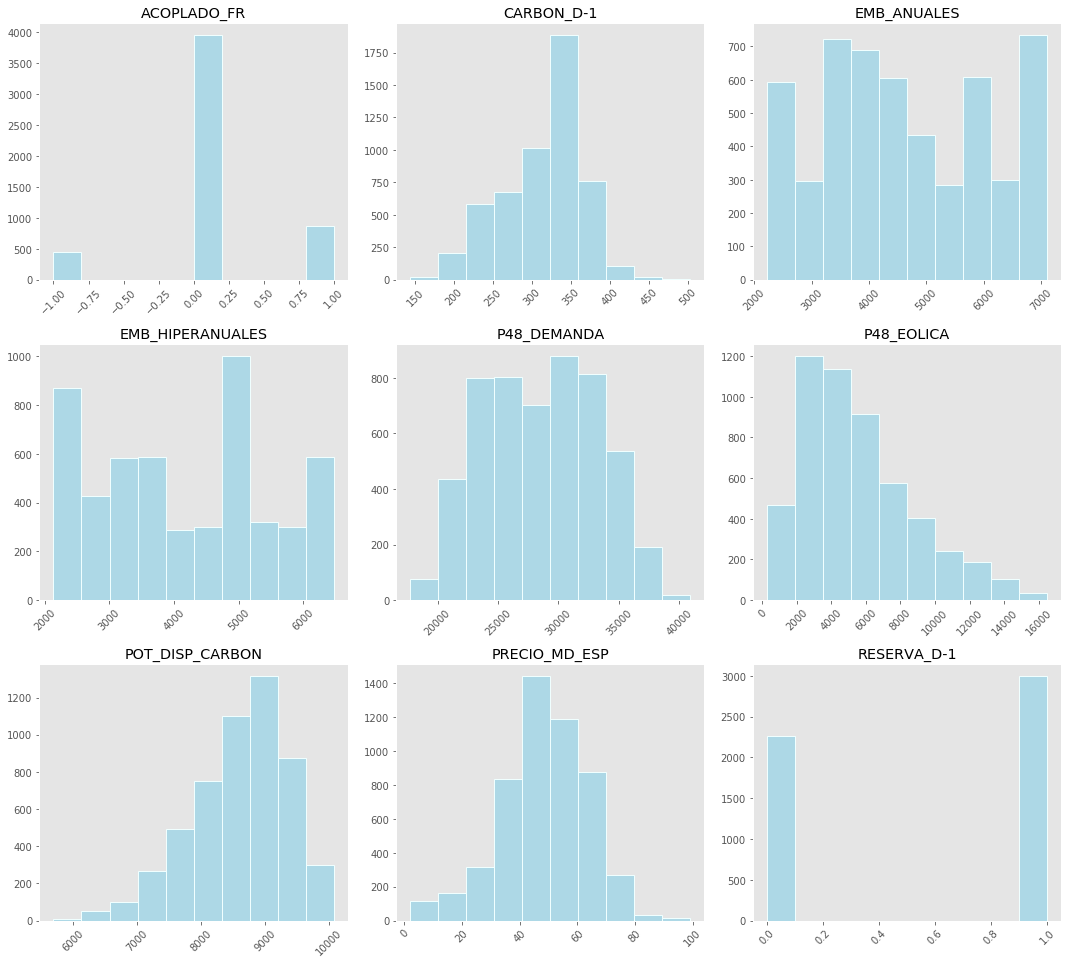

In [11]:
fig = X_test.drop(['MES','PERIODO','WD'],axis=1).hist(color='lightblue',
                                                    edgecolor='azure', linewidth=1.0,
                                                    xlabelsize=10, ylabelsize=10,
                                                    xrot=45, yrot=0,
                                                    figsize=(10,9),
                                                    grid=False)
plt.tight_layout(rect=(0, 0, 1.5, 1.5))  

### 2) Pruebo diferentes modelos

* Utilizo GridSearchCV para ajustar hiperparámetros.


#### a) KNN

In [12]:
clfk_0 = KNeighborsClassifier()
print(clfk_0.get_params())

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


Parámetros a seleccionar: 

* n_neighbors

* scoring

In [13]:
clfk=GridSearchCV(KNeighborsClassifier(n_neighbors=1),
                 param_grid={"n_neighbors": [1,2,3,4,5,10,50,100]},
                 scoring="accuracy",
                 cv=10)

clfk.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [14]:
clfk.best_params_

{'n_neighbors': 3}

In [15]:
clfk.best_score_

0.6381178707224334

In [16]:
clfk_1=clfk.best_estimator_

In [17]:
clfk_1.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [18]:
accuracy_score(y_test, clfk_1.predict(X_test))

0.6468352024329975

#### b) SVC

In [25]:
clfsvc_0=SVC(random_state=42)
print(clfsvc_0.get_params())

{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}


Parámetros a seleccionar: 

* kernel

* gamma

* C

In [98]:
clfsvc=GridSearchCV(SVC(kernel="rbf",C=1,gamma=1,random_state=42),  
                 param_grid={"gamma": [10,100,1000,10000],"C":[10,100,1000]},  
                 scoring="accuracy",
                 cv=5)
clfsvc.fit(X_train,y_train)

KeyboardInterrupt: 

In [26]:
clfsvc.best_params_

NameError: name 'clfsvc' is not defined

In [ ]:
clfsvc.best_score_

#### c) Decission Tree

In [27]:
clfd_0=DecisionTreeClassifier(random_state=42)
print(clfd_0.get_params())

{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 42, 'splitter': 'best'}


Parámetros a seleccionar: 

* min_samples_leaf

* max_depth


In [28]:
clfd = GridSearchCV(DecisionTreeClassifier(min_samples_leaf=20,max_depth=3,random_state=42),
                            param_grid={"min_samples_leaf": [10,20,30,50,100,150,200,250], "max_depth":range(2,7)},
                               scoring="accuracy",
                               cv=10)
clfd.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [10, 20, 30, 50, 100, 150, 200, 250], 'max_depth': range(2, 7)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [29]:
clfd.best_params_

{'max_depth': 6, 'min_samples_leaf': 20}

In [30]:
clfd.best_score_

0.6059885931558935

In [31]:
clfd_1=clfd.best_estimator_

In [32]:
clfd_1.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

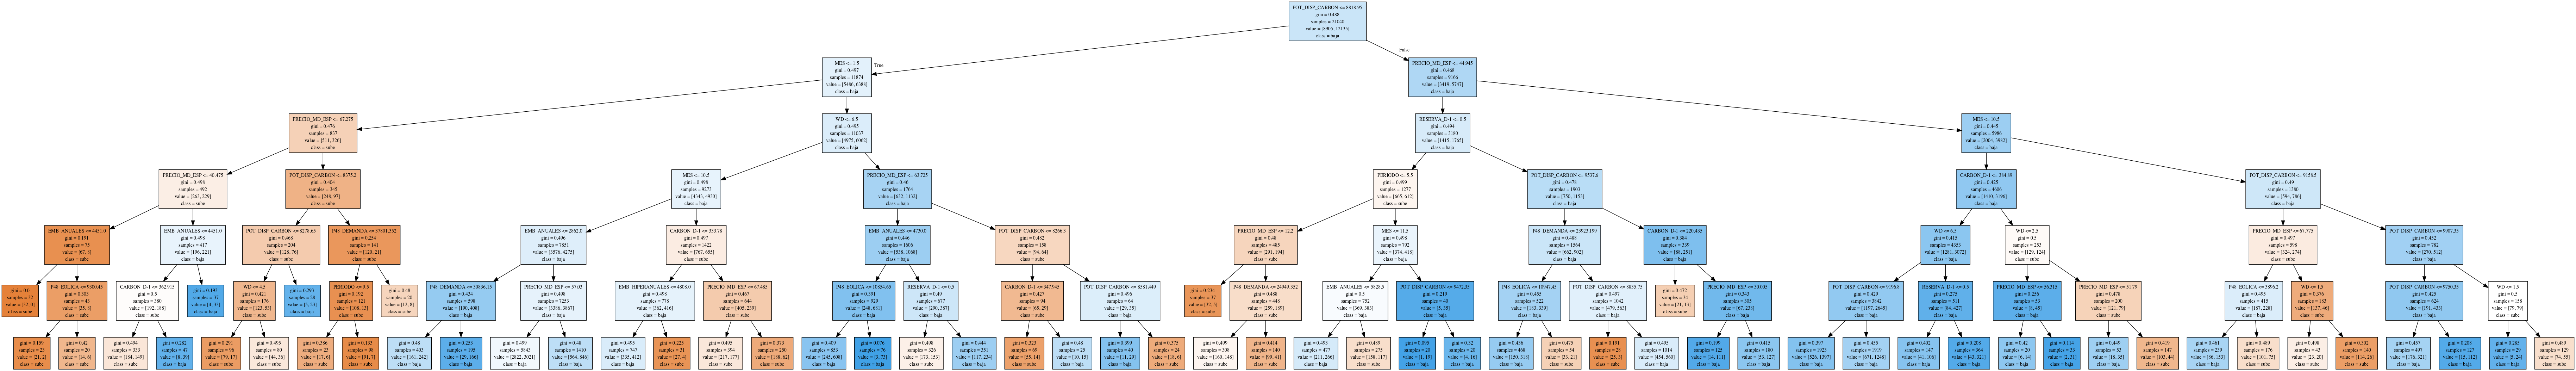

In [33]:
dot_data = tree.export_graphviz(clfd_1,
                                out_file=None, 
                                filled=True,                           #filled le pone un color en funcion de la clase
                                feature_names=attributes_column,
                                class_names=["sube","baja"])            

graph=pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [34]:
accuracy_score(y_test, clfd_1.predict(X_test))

0.6076791484508649

In [35]:
importances = clfd_1.feature_importances_

indices = np.argsort(importances)[::-1]

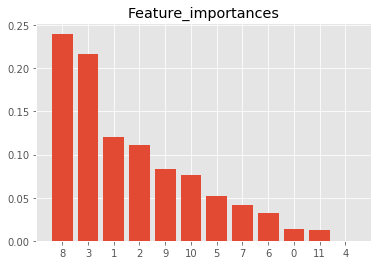

['POT_DISP_CARBON', 'PRECIO_MD_ESP', 'MES', 'WD', 'CARBON_D-1', 'EMB_ANUALES', 'RESERVA_D-1', 'P48_DEMANDA', 'P48_EOLICA', 'PERIODO', 'EMB_HIPERANUALES', 'ACOPLADO_FR']


In [36]:
plt.figure()
plt.title("Feature_importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

print(list([attributes_column[i] for i in indices]))

**NOTA:** Probaré después si mejora el score al eliminar ACOPLADO_FR, EMB_HIPERANUALES, PERIODO.

#### d) Random Forest

In [37]:
clfr_0=RandomForestClassifier(random_state=42)
print(clfr_0.get_params())

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Parámetros a seleccionar:

* min_samples_leaf

* max_depth

* n_estimators

In [38]:
clfr = GridSearchCV(RandomForestClassifier(n_estimators=200, oob_score=True,random_state=42),
                          param_grid={"min_samples_leaf": [10, 20, 30, 50, 100, 150, 200, 250,500],
                                      'max_depth': range(2, 7, 500),
                                      'n_estimators': [100, 200, 500]},
                          scoring="accuracy",
                          cv=10)
clfr.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [10, 20, 30, 50, 100, 150, 200, 250, 500], 'max_depth': range(2, 7, 500), 'n_estimators': [100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [39]:
clfr.best_params_

{'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 500}

In [40]:
clfr.best_score_

0.5815114068441065

In [41]:
clfr_1=clfr.best_estimator_

In [42]:
clfr_1.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [43]:
accuracy_score(y_test, clfr_1.predict(X_test))

0.5784071469302414

In [44]:
importances = clfr_1.feature_importances_

indices = np.argsort(importances)[::-1]

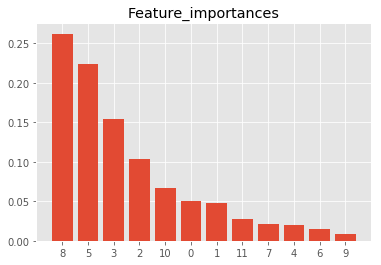

['POT_DISP_CARBON', 'RESERVA_D-1', 'PRECIO_MD_ESP', 'WD', 'EMB_ANUALES', 'PERIODO', 'MES', 'EMB_HIPERANUALES', 'P48_DEMANDA', 'ACOPLADO_FR', 'P48_EOLICA', 'CARBON_D-1']


In [45]:
plt.figure()
plt.title("Feature_importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

print(list([attributes_column[i] for i in indices]))

**NOTA**: En RandomForest obtenemos CARBON_D-1 es la variable que menos aporta al modelo. Continúa estando ACOPLADO_FR entre las menos importantes

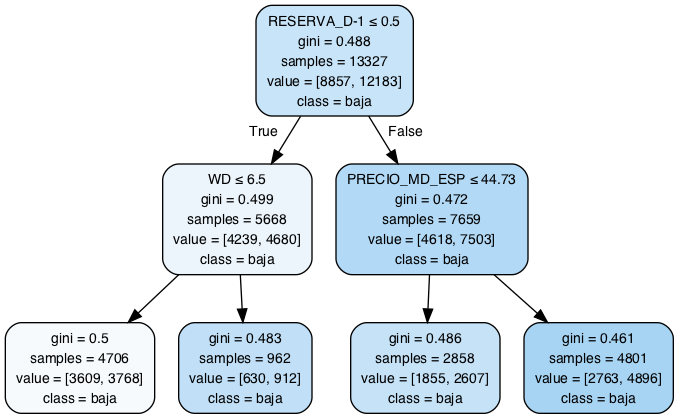

In [46]:
dot_data = tree.export_graphviz(clfr_1.estimators_[1], out_file=None, 
                         filled=True, rounded=True,  
                         special_characters=True,
                         feature_names=attributes_column,
                         class_names=["sube","baja"])  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png()) 

#### e) XGBOOST

In [47]:
clfxb_0=XGBClassifier(random_state=42)
print(clfxb_0.get_params())

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}


Parámetros a seleccionar: 

* n_estimators

In [48]:
clfxb = GridSearchCV(XGBClassifier(n_estimators=100,random_state=42),
                    param_grid={'n_estimators': [100, 200, 500]},
                    scoring="accuracy",
                    cv=5)
clfxb.fit(X_train,y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [49]:
clfxb.best_score_

0.6826520912547529

In [50]:
clfxb.best_params_

{'n_estimators': 500}

In [51]:
clfxb_1=clfxb.best_estimator_

In [52]:
clfxb_1.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [53]:
accuracy_score(y_test, clfxb_1.predict(X_test))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6962554647405437

In [54]:
importances = clfxb_1.feature_importances_

indices = np.argsort(importances)[::-1]

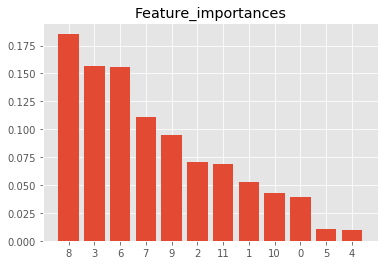

['POT_DISP_CARBON', 'PRECIO_MD_ESP', 'P48_EOLICA', 'P48_DEMANDA', 'CARBON_D-1', 'WD', 'EMB_HIPERANUALES', 'MES', 'EMB_ANUALES', 'PERIODO', 'RESERVA_D-1', 'ACOPLADO_FR']


In [55]:
plt.figure()
plt.title("Feature_importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

print(list([attributes_column[i] for i in indices]))

**NOTA:** Como se intuía en la exploración de datos, la variable ACOPLADO_FR no aporta a los modelos

#### f) Bagging

In [56]:
clfb_0=BaggingClassifier(base_estimator=clfk.best_estimator_,random_state=42)
print(clfxb_0.get_params())

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}


Parámetros a escoger:

* n_estimators

In [57]:
clfb = GridSearchCV(BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=3),n_estimators=100,oob_score=True,random_state=42),
                    param_grid={"n_estimators": [100, 200, 500]},
                    scoring="accuracy",
                    cv=5)
clfb.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=100, n_jobs=1, oob_score=True,
         random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [58]:
clfb.best_score_

0.6387832699619772

In [59]:
clfb.best_params_

{'n_estimators': 200}

In [60]:
clfb_1=clfb.best_estimator_
clfb_1.fit(X_train,y_train)

BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=200, n_jobs=1, oob_score=True,
         random_state=42, verbose=0, warm_start=False)

In [61]:
accuracy_score(y_test, clfb_1.predict(X_test))

0.6525375403915605

### 3) Análisis de resultados:

#### a) KNN

In [62]:
print(classification_report(y_test,clfk_1.predict(X_test)))

             precision    recall  f1-score   support

          0       0.60      0.55      0.57      2258
          1       0.68      0.72      0.70      3003

avg / total       0.64      0.65      0.64      5261



In [63]:
cmat=confusion_matrix(y_test,clfk_1.predict(X_test))

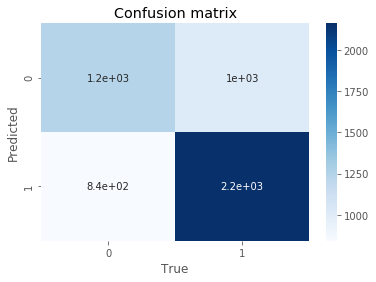

In [64]:
plt.figure()
sns.heatmap(cmat, 
            annot=True,
            xticklabels=[0,1], 
            yticklabels=[0,1],
            cmap='Blues')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.title('Confusion matrix')
plt.show()

* **Falsos 1:** Perdería dinero si compro en el MI1 -> es el que menos valores tiene.

* **Falsos 0:** Viendo que practicamente tengo el mismo número de falsos 0 que de verdaderos 0, ante un 0 en el modelo, no arriesgaría comprando de más en el MD y vendiendo después en el MI1, simplemente no haría nada (que no supone pérdida econímica real, solo pérdida de oportunidad).